Notebook 2: predicting animal intakes over time

In [1]:
import pandas as pd
import numpy as np
import pymc3
import matplotlib.pyplot as plt
from plotnine import *
import itertools
import statsmodels.api as sm
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from fbprophet import Prophet
from pylab import rcParams
df = pd.read_csv('sac_animals.csv')

Convert the data to a time weekly time series and drop the very first and last weeks since they are partial weeks

In [2]:
df['intake_date'] = pd.to_datetime(df['intake_date'])
df['outcome_date'] = pd.to_datetime(df['outcome_date'])
df['n'] = 1

df_dt = df.set_index('intake_date')
y = df_dt['n'].resample('W').sum()
y = y[(y.index > '2017-12-03') & (y.index < '2020-12-06')]

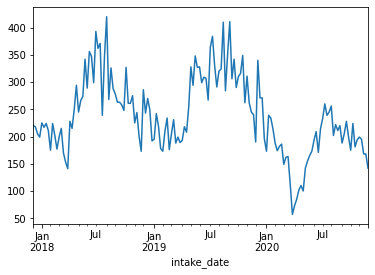

In [3]:
y.plot()
plt.show()

Decompose the time series

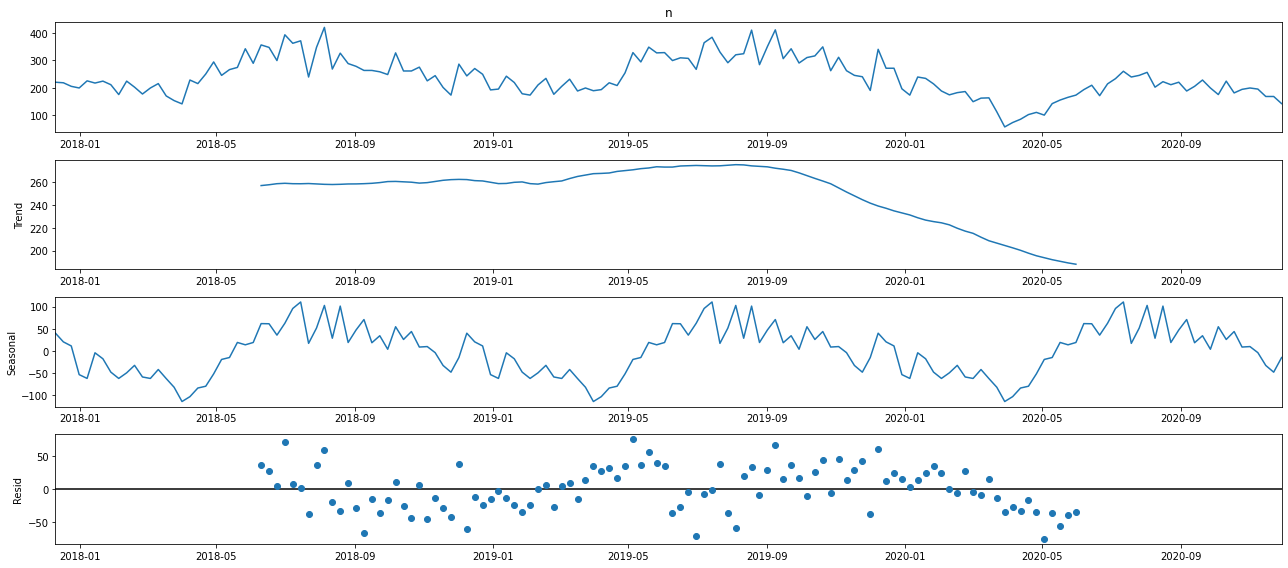

In [4]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

Truncated version of the ARIMA grid search to find optimal pdq parameters

In [5]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 52)
SARIMAX: (0, 0, 1) x (0, 1, 0, 52)
SARIMAX: (0, 1, 0) x (0, 1, 1, 52)
SARIMAX: (0, 1, 0) x (1, 0, 0, 52)


In [6]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}52 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 52)52 - AIC:2152.5876913257925


/Users/justingoss/Desktop/sac_animals/sac_animals/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.


ARIMA(0, 0, 0)x(0, 0, 1, 52)52 - AIC:1377.3179637127876
ARIMA(0, 0, 0)x(0, 1, 0, 52)52 - AIC:1212.6677860855916
ARIMA(0, 0, 0)x(0, 1, 1, 52)52 - AIC:617.0757096465784
ARIMA(0, 0, 0)x(1, 0, 0, 52)52 - AIC:1195.770607044285
ARIMA(0, 0, 0)x(1, 0, 1, 52)52 - AIC:1157.625936692249
ARIMA(0, 0, 0)x(1, 1, 0, 52)52 - AIC:627.4957634404675
ARIMA(0, 0, 0)x(1, 1, 1, 52)52 - AIC:615.7690122630693
ARIMA(0, 0, 1)x(0, 0, 0, 52)52 - AIC:1957.7705050593668
ARIMA(0, 0, 1)x(0, 0, 1, 52)52 - AIC:1254.7635958666272
ARIMA(0, 0, 1)x(0, 1, 0, 52)52 - AIC:1164.6212968086625
ARIMA(0, 0, 1)x(0, 1, 1, 52)52 - AIC:570.4668376351564
ARIMA(0, 0, 1)x(1, 0, 0, 52)52 - AIC:1161.5256995932723
ARIMA(0, 0, 1)x(1, 0, 1, 52)52 - AIC:1114.961703846781
ARIMA(0, 0, 1)x(1, 1, 0, 52)52 - AIC:589.6861772353404
ARIMA(0, 0, 1)x(1, 1, 1, 52)52 - AIC:565.3720086418535
ARIMA(0, 1, 0)x(0, 0, 0, 52)52 - AIC:1615.3281214238336
ARIMA(0, 1, 0)x(0, 0, 1, 52)52 - AIC:1054.5076901648024
ARIMA(0, 1, 0)x(0, 1, 0, 52)52 - AIC:1143.0029658040485
A

Fit ARIMA model

In [7]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 52),
                                enforce_stationarity=True,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6608      0.076     -8.740      0.000      -0.809      -0.513
ma.S.L52      -1.0001   1274.019     -0.001      0.999   -2498.032    2496.032
sigma2      1276.3286   1.63e+06      0.001      0.999   -3.19e+06    3.19e+06


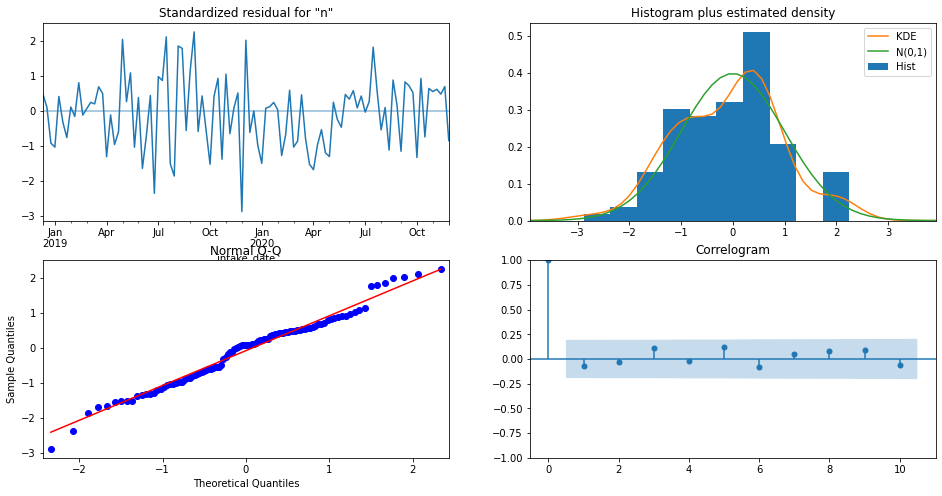

In [8]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

Check model against past data, not perfect but pretty good

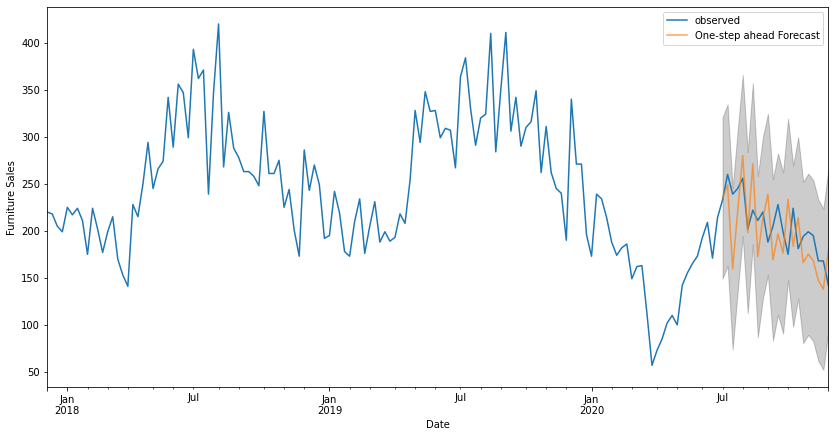

In [9]:
pred = results.get_prediction(start=pd.to_datetime('2020-07-05 00:00:00+00:00'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

Use model to predict data, performs well, appropriately capturing seasonality. It does index a bit low though because of the drop in adoptions in 2020 likely caused by COVID, we'd expect the counts to rebound after COVID in 2021.

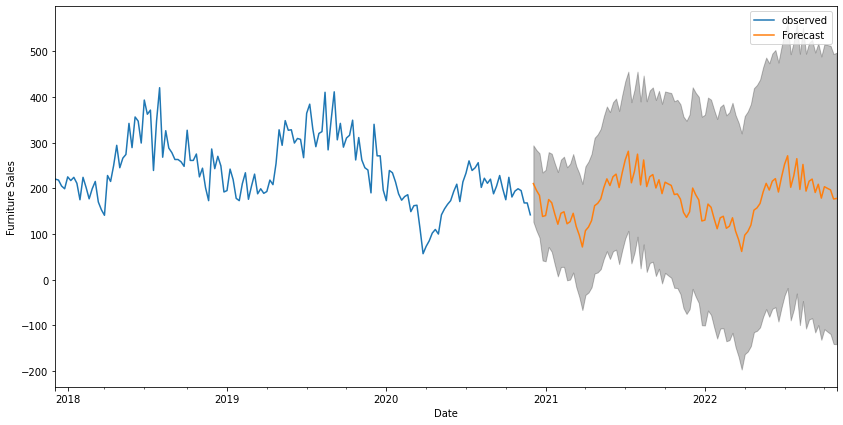

In [10]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

Try Facebook's Prophet model. Unfortunately this performs worse, as the model predicts the yearly decrease will continue year over year and predicts intakes will continue to decline.

In [11]:
p_model = Prophet(interval_width=0.95, weekly_seasonality=True)
y_prophet = y.reset_index().rename(columns={'intake_date': 'ds', 'n': 'y'})
y_prophet['ds'] = y_prophet['ds'].dt.tz_localize(None)
p_model.fit(y_prophet)
y_forecast = p_model.make_future_dataframe(periods=36, freq='W')
y_forecast = p_model.predict(y_forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


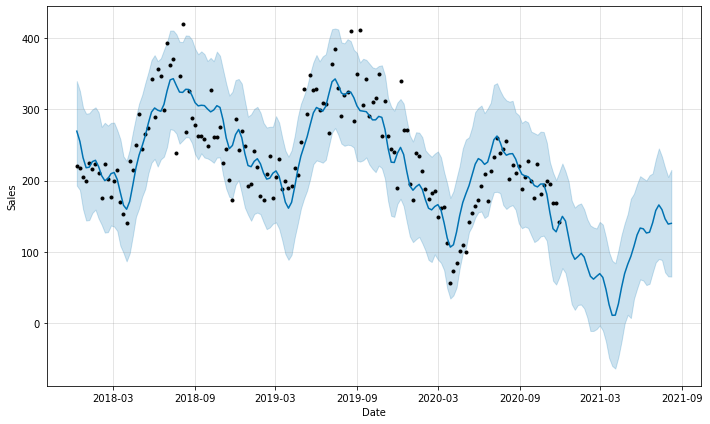

<Figure size 1296x432 with 0 Axes>

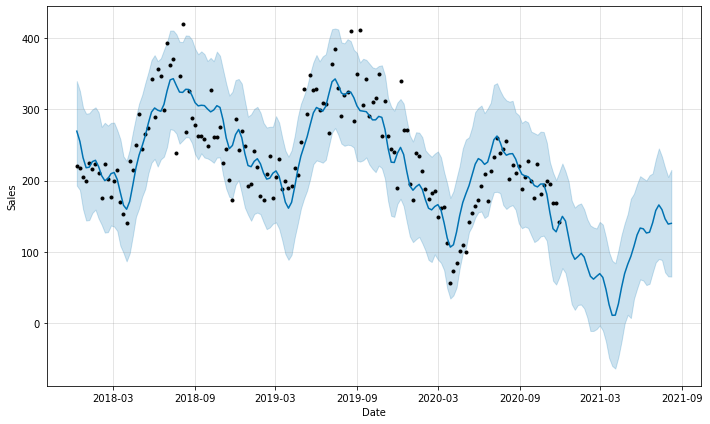

In [12]:
plt.figure(figsize=(18, 6))
p_model.plot(y_forecast, xlabel = 'Date', ylabel = 'Sales')